In [1]:
from avian_vocalizations import data
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
from avian_vocalizations.data import AudioFeatureGenerator
from avian_vocalizations.model import ModelFactory
from sklearn.preprocessing import LabelEncoder
import os
from glob import glob
import numpy as np
import warnings; warnings.simplefilter('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

data_dir = '../data'
index_df, shapes_df, train_df, test_df = data.load_data(data_dir)

label_encoder = LabelEncoder().fit(index_df['english_cname'] )

n_classes = len(label_encoder.classes_)
print("The dataset contains %i distinct species labels."%n_classes)

Using TensorFlow backend.


The dataset contains 91 distinct species labels.


In [2]:
cnn = ModelFactory(n_classes)
cnn.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)        0         
______________________________________

In [3]:
cnn.load_weights(os.path.join(data_dir,"weights.best.hdf5"))

In [4]:
X_test = index_df.loc[index_df['test']==True].index.values
y_test = label_encoder.transform(index_df.loc[index_df['test']==True,"english_cname"].values)

test_generator = AudioFeatureGenerator(X_test, y_test, batch_size=len(X_test), data_dir=data_dir,
                                       seed=37, n_frames=128, n_classes=n_classes)

Xs, ys = test_generator[0] # batch_size=len(X_test), so one batch has all test samples. 

predictions = cnn.predict(Xs) 
test_accuracy = accuracy_score(np.argmax(ys,axis=1), np.argmax(predictions, axis=1))
print("Test accuracy of CNN model: %.5f"%test_accuracy)


Test accuracy of CNN model: 0.24066


## Confusion Matrix

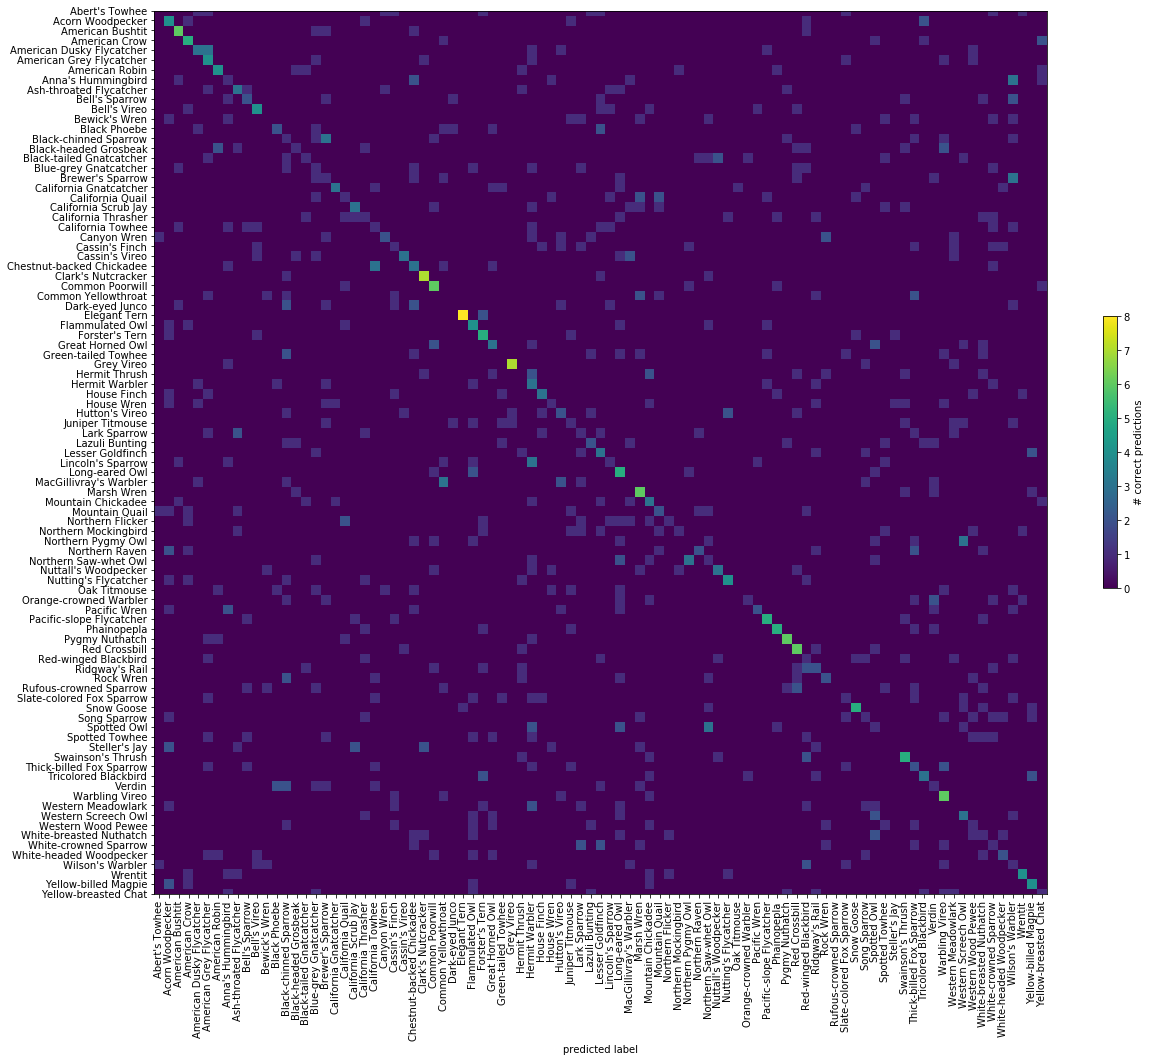

In [5]:
y_predicted = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_test, y_predicted, labels=range(n_classes))
plt.figure(figsize=(20,20))
plt.imshow(conf_matrix)
plt.xticks(range(n_classes), label_encoder.classes_, rotation='vertical')
plt.xlabel("true label")
plt.yticks(range(n_classes), label_encoder.classes_)
plt.xlabel("predicted label")
plt.colorbar(shrink=.25, label='# correct predictions');

## Correlation between Accuracy and Total duration of audio

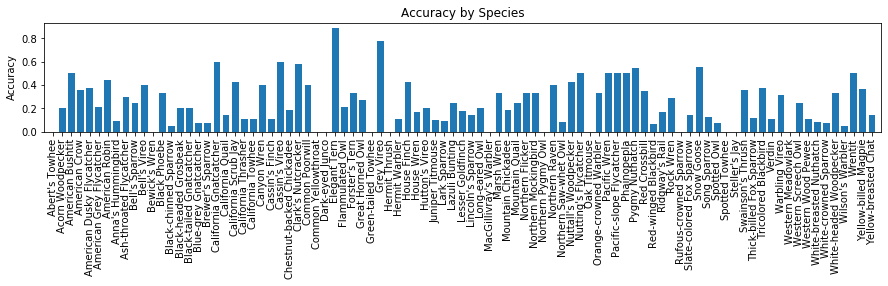

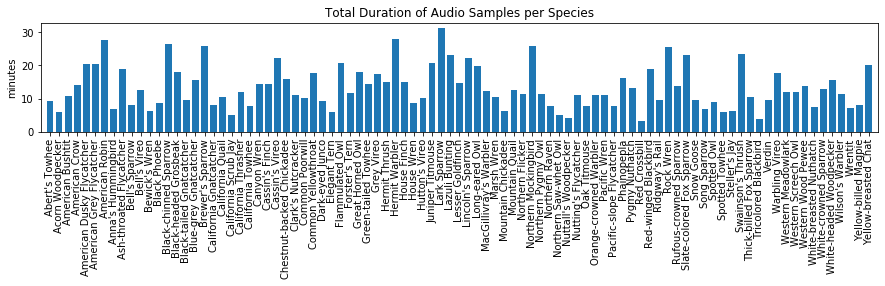

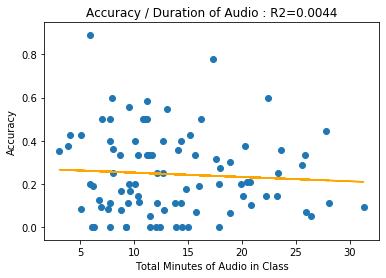

In [17]:
# Is there a correlation between total duration of audio and class accuracy?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pct_correct_by_class = np.zeros(n_classes)
counts = np.sum(conf_matrix,axis=0)
np.divide(np.array([conf_matrix[i,i] for i in range(n_classes)]), counts, 
          out=pct_correct_by_class, where=counts!=0)
plt.figure(figsize=(15,2))
plt.bar(range(n_classes), pct_correct_by_class, .75); plt.xlim(-1,91)
plt.xticks(range(n_classes), label_encoder.classes_, rotation='vertical')
plt.title("Accuracy by Species")
plt.ylabel("Accuracy")
plt.show();

duration_by_class=[index_df.loc[index_df.english_cname==y,'duration_seconds'].sum()/60 for y in label_encoder.classes_]
plt.figure(figsize=(15,2))
plt.title("Total Duration of Audio Samples per Species")
plt.bar(range(n_classes), duration_by_class, .75); plt.xlim(-1,91)
plt.ylabel("minutes")
# plt.xticks([],[])
plt.xticks(range(n_classes), label_encoder.classes_, rotation='vertical')
plt.show();

lin_model = LinearRegression()
lin_model.fit(np.array(duration_by_class).reshape(-1,1), pct_correct_by_class.reshape(-1,1))
pred = lin_model.predict(np.array(duration_by_class).reshape(-1,1))
# mse = mean_squared_error(pct_correct_by_class,pred)
r2 = r2_score(pct_correct_by_class, pred)

plt.title("Accuracy / Duration of Audio : R2=%.4f"%(r2))
plt.scatter(np.array(duration_by_class),pct_correct_by_class)
plt.plot(duration_by_class, pred, 'orange')
plt.xlabel('Total Minutes of Audio in Class')
plt.ylabel('Accuracy');

## Stability testing

Changing the `seed` value passed to `AudioFeatureGenerator` will change the crop windows for each sample. Let's see how accuracy varies with successive test rounds in order to assess model stability.  

In [6]:
res = []
for i in range(5):
    test_generator = AudioFeatureGenerator(X_test, y_test, batch_size=len(X_test), data_dir=data_dir,
                                       seed=37+i, n_frames=128, n_classes=n_classes)
    Xs, ys = test_generator[0] 

    predictions = cnn.predict(Xs) 
    test_accuracy = accuracy_score(np.argmax(ys,axis=1), np.argmax(predictions, axis=1))
    res.append(test_accuracy)
    print("Epoch %i test accuracy: %.5f"%(i+1,test_accuracy))
print("Mean test accuracy: %.5f, Std. deviation: %.5f"%(np.mean(res), np.std(res)))

Epoch 1 test accuracy: 0.24066
Epoch 2 test accuracy: 0.22418
Epoch 3 test accuracy: 0.22198
Epoch 4 test accuracy: 0.22198
Epoch 5 test accuracy: 0.23077
Mean test accuracy: 0.22791, Std. deviation: 0.00714


## Download a sample and make a prediction

In [7]:
from requests import get
import librosa
from IPython.display import Audio
resp = get("https://www.xeno-canto.org/449570/download")
if resp.ok:
    with open('test_sample.mp3','wb') as f:
        
        f.write(resp.content)
else:
    raise("Error downloading sample. Do you have internet access?")
data, sr = librosa.load('test_sample.mp3')
display(Audio(data, rate=sr))

In [8]:
from avian_vocalizations.data import get_scalers
# from librosa.display import specshow

melsg_scaler, melsg_log_scaler, mfcc_scaler = get_scalers(index_df, data_dir='../data')
sg = librosa.feature.melspectrogram(data, sr=sr, hop_length=512, n_fft=2048)
sg_lognorm = melsg_log_scaler.transform(np.log(sg))
mfcc = librosa.feature.mfcc(data, sr=sr, hop_length=512, n_fft=2048)
mfcc_norm = mfcc_scaler.transform(mfcc)
# Grab the first 128 frames
sg_lognorm_cropped = sg_lognorm[:, :128]
mfcc_norm_cropped = mfcc_norm[:, :128]
X = sg_lognorm_cropped.copy()
X[:20] = mfcc_norm_cropped
# Visualize it
# specshow(X, x_axis='s', y_axis='mel')
# plt.colorbar()
# Make a prediction
predictions = cnn.predict([X.reshape(1,*X.shape,1)])
predicted_label = label_encoder.classes_[np.argmax(predictions)]
print("The vocalization is predicted to be from a "+predicted_label)

The vocalization is predicted to be from a Phainopepla


## Module Versions

In [9]:
from avian_vocalizations.toolbench import print_module_versions
print_module_versions(globals())

             IPython  {'7.9.0'}
             sklearn  {'0.21.3'}
          matplotlib  {'3.1.1'}
 avian_vocalizations  {'0.1.0'}
               numpy  {'1.17.3'}
              pandas  {'0.25.2'}
               keras  {'2.3.1'}
            requests  {'2.22.0'}
             librosa  {'0.7.1'}
